In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [39]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet import OldGraphConvNet
from core.GraphConvNet import GraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphDataBlock import GraphDataBlock
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import graph_trustworthiness, trustworthiness
from util.network_utils import get_net_projection
from util.graph_utils import get_shortest_path_matrix, neighbor_sampling

In [4]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [6]:
dataset_name = 'pubmed'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)
dataset.summarise()

Time to create all data (s) = 0.0391
Name of dataset = pubmed
Input dimension = 500
Number of training samples = 19717
Training labels = True
Graph information = True


In [7]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 2 # number of hidden layers

In [8]:
# Graph net
net_1 = GraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/pubmed_5/'
filename = root + 'graph_net_5.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])

In [9]:
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)

Time to create all data (s) = 0.0168


In [10]:
y_pred_1 = get_net_projection(dataset.all_data, net_1)

In [11]:
plot_graph_embedding(y_pred_1, dataset.labels, dataset.adj_matrix, line_alpha=0)

In [129]:
n_plot = 50
D_layers = [4, 9]
mask = np.random.choice(dataset.all_indices, size=n_plot, replace=False)
mask = neighbor_sampling(dataset.adj_matrix, mask, D_layers)
inputs = dataset.inputs[mask]
labels = dataset.labels[mask]
W = dataset.adj_matrix[mask, :][:, mask]
print(len(mask))
G = GraphDataBlock(inputs, labels, W)

775


In [130]:
y_emb = get_net_projection([G], net_1)
plot_graph_embedding(y_emb, labels, W, line_alpha=0.1)

In [131]:
# Simple net
net_2 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/pubmed_4/'
filename = root + 'simple_net_5.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])

In [132]:
y_pred_2 = get_net_projection(dataset.all_data, net_2)

In [133]:
plot_graph_embedding(y_pred_2, dataset.labels, dataset.adj_matrix, line_alpha=0)

In [134]:
y_emb_2 = get_net_projection([G], net_2)
plot_graph_embedding(y_emb_2, labels, W, line_alpha=0.1)

In [135]:
path_matrix = get_shortest_path_matrix(W.toarray())
path_matrix.shape

Computing all pairs shortest path lengths for 775 nodes...
Time to compute shortest paths (s) = 1.8729


(775, 775)

In [136]:
embedder = TSNE(n_components=2, metric='precomputed', perplexity=30, verbose=1)
y_pred_tsne = embedder.fit_transform(path_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 775 samples in 0.001s...
[t-SNE] Computed neighbors for 775 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 775 / 775
[t-SNE] Mean sigma: 0.896327
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.030998
[t-SNE] KL divergence after 1000 iterations: 0.448118


In [137]:
plot_graph_embedding(y_pred_tsne, labels, W, line_alpha=0.1)

In [138]:
# embeddings_dict = {r'tsne ($\alpha=0)$': y_pred_tsne,
#                    r'tsne ($\alpha=1)$': y_pred_tsne_2}

In [139]:
embeddings_dict = {r'graph net ($\alpha=0.5$)': y_emb,
                   r'simple net ($\alpha=0.5$)': y_emb_2,
                  'tsne': y_pred_tsne}

In [140]:
def neighborhood_preservation(path_matrix, X_emb, max_graph_dist=2):
    dist_X_emb = pairwise_distances(X_emb, squared=True)
    ind_X_emb = np.argsort(dist_X_emb, axis=1)[:, 1:]

    n_samples = X_emb.shape[0]
    t = 0.0
    for i in range(n_samples):
        graph_n = {k for k, v in enumerate(path_matrix[i]) if 0 < v <= max_graph_dist}
        if len(graph_n) == 0:
            t += 1
            continue
        layout_n = set(ind_X_emb[i][:len(graph_n)])
        intersection_size = len(graph_n.intersection(layout_n))
        # print(len(graph_n), intersection_size)
        t += intersection_size / (2*len(graph_n) - intersection_size)
    return t/n_samples

Text(0.5,1,'Graph preservation')

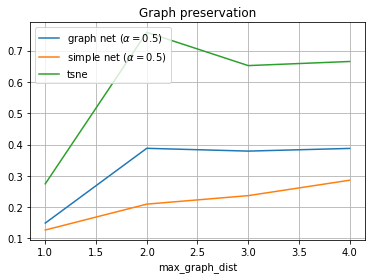

In [141]:
test_range = list(range(1, 5))
scores = np.zeros(len(test_range))

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = neighborhood_preservation(path_matrix, embedding, max_graph_dist=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('max_graph_dist')
plt.grid(True)
plt.title('Graph preservation')

Text(0.5,1,'Feature preservation')

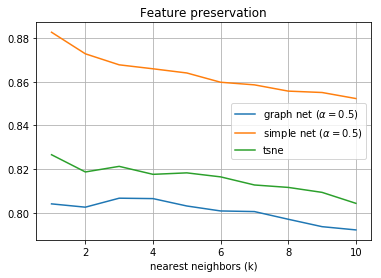

In [142]:
test_range = list(range(1, 11))
scores = np.zeros(len(test_range))

D = pairwise_distances(inputs, metric='cosine')

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = trustworthiness(D, embedding, precomputed=True, n_neighbors=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('nearest neighbors (k)')
plt.grid(True)
plt.title('Feature preservation')

In [143]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)

In [144]:
labels_pred = kmeans.fit_predict(y_emb)

In [146]:
plot_graph_embedding(y_emb, labels_pred, W, line_alpha=0.1)

In [147]:
labels_pred_2 = kmeans.fit_predict(y_emb_2)

In [148]:
plot_graph_embedding(y_emb_2, labels_pred_2, W, line_alpha=0.1)

In [149]:
adj = sp.coo_matrix(W)

197.0651818215847


(array([1696.,  364.,  144.,   46.,   26.,    6.,    2.,    0.,    4.,
           2.]),
 array([0.00111072, 0.10099965, 0.20088857, 0.3007775 , 0.40066645,
        0.50055534, 0.6004443 , 0.70033324, 0.80022216, 0.9001111 ,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

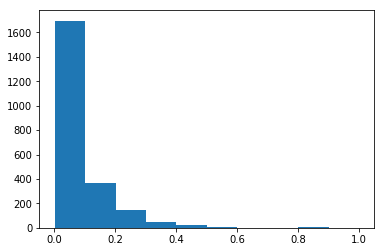

In [150]:
p0 = y_emb[adj.row, :]
p1 = y_emb[adj.col, :]
dist = np.linalg.norm(p0-p1, axis=1)
dist = dist/max(dist)
print(sum(dist))
plt.hist(dist)

300.91436970152427


(array([1368.,  390.,  240.,  116.,   64.,   40.,   44.,   16.,    6.,
           6.]),
 array([5.6917925e-04, 1.0051226e-01, 2.0045534e-01, 3.0039844e-01,
        4.0034151e-01, 5.0028461e-01, 6.0022765e-01, 7.0017076e-01,
        8.0011386e-01, 9.0005690e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

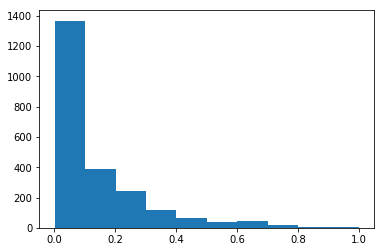

In [151]:
p0 = y_emb_2[adj.row, :]
p1 = y_emb_2[adj.col, :]
dist = np.linalg.norm(p0-p1, axis=1)
dist = dist/max(dist)
print(sum(dist))
plt.hist(dist)